**Author:** Oguz Alp Eren

**Instructor:** Michael D. Parrott

Projects in Advanced Machine Learning 2023, Columbia University

You can find this report at this GitHub repository https://github.com/OguzAlpEren/Oguz-Alp-Eren-Advanced-ML-Projects

# **Assignment 2, Covid Positive X-Ray image data**

**References:**

M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, “Can AI help in screening Viral and COVID-19 pneumonia?” arXiv preprint, 29 March 2020, https://arxiv.org/abs/2003.13145


## 1. Uploading the data

1. Use Google Drive link to view a folder I shared with @columbia.edu google drive users
https://drive.google.com/drive/folders/18O-BnGOIw9ZiUwy17Uk_361xyfTF-qAN?usp=sharing
2. Right click folder and click "Add shortcut to Drive"
This will be sure the zipfile in this folder is accessible in your personal drive folder


In [ ]:
# Connect to google drive
import os
from google.colab import drive
drive.mount('/content/drive')

# content in your drive is now available via "/content/drive/My Drive"

Mounted at /content/drive


In [ ]:
# Import data and unzip files to folder
!unzip /content/drive/MyDrive/COVID-19_Radiography_Dataset.zip

In [ ]:
# Load libraries and then download data

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3


In [ ]:
# Extracting all filenames iteratively
base_path = 'COVID-19_Radiography_Dataset'
categories = ['COVID/images', 'Normal/images', 'Viral Pneumonia/images']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:2]) #examples of file names

number of images for each category: [3616, 10192, 1345]
[['COVID-19_Radiography_Dataset/COVID/images/COVID-1960.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-904.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2435.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-787.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2157.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1257.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3379.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-819.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1690.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1338.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3508.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1990.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-617.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3309.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2410.png', 'COVID-19_Radiography_Dataset/COVID/images/COV

In [ ]:
#Reduce number of images to first 1345 for each category
fnames[0]=fnames[0][0:1344]
fnames[1]=fnames[1][0:1344]
fnames[2]=fnames[2][0:1344]

In [ ]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
from keras.preprocessing import image
import numpy as np
from PIL import Image

def preprocessor(img_path):
        img = Image.open(img_path).convert("RGB").resize((192,192)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-1.)/(255-1.) # min max transformation
        img=img.reshape((192,192,3)) # Create final shape as array with correct dimensions for Keras
        return img



#Try on single flower file (imports file and preprocesses it to data with following shape)
preprocessor('COVID-19_Radiography_Dataset/COVID/images/COVID-2273.png').shape

(192, 192, 3)

In [ ]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [ ]:
len(image_filepaths)

4032

In [ ]:
print(len(X) ) #same number of elements as filenames
print(X.shape ) #dimensions now 192,192,3 for all images
print(X.min().round() ) #min value of every image is zero
print(X.max() ) #max value of every image is one


4032
(4032, 192, 192, 3)
-0.0
1.0


In [ ]:
len(fnames[2])

1344

In [ ]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder 
#...corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1344, 1344, 1344]
4032


,COVID,NORMAL,PNEUMONIA
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
4027,0,0,1
4028,0,0,1
4029,0,0,1
4030,0,0,1


## 2. Visualize images that demonstrate when x-rays demonstrate Covid Positivity and when they do not. 

I demostrated positive x-rays for COVID and not for PNEUMONIA. NORMAL and PNEUMONIA are demonstrated as covid negative in this case.

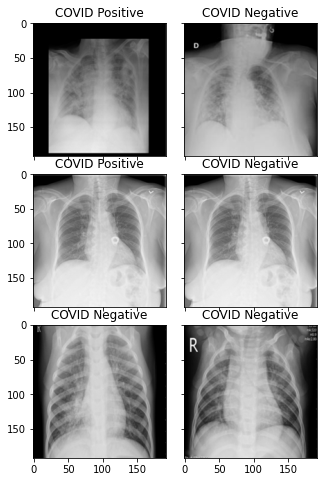

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

im1 = preprocessor(fnames[0][0])
im2 = preprocessor(fnames[0][1])
im3 = preprocessor(fnames[1][1])
im4 = preprocessor(fnames[1][1])
im5 = preprocessor(fnames[2][1])
im6 = preprocessor(fnames[2][2])

fig = plt.figure(figsize=(8., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 2),  # creates 3x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4, im5, im6]):
    # get a random label index for the current image
    label_idx = random.randint(0, len(y_labels) - 1)
    # set the title based on the label
    title = 'COVID Positive' if y_labels[label_idx] == 'COVID' else 'COVID Negative'
    # show the image and title
    ax.imshow(im)
    ax.set_title(title)

plt.show()

## 3. Discuss the dataset in general terms and describe why building a predictive model using this data might be practically useful.  Who could benefit from a model like this? Explain.

The dataset used in this study was created by combining several publicly available databases and collecting images from recently published articles. It includes a mixture of 423 COVID-19 positive chest X-ray images, 1485 viral pneumonia images, and 1579 normal chest X-ray images. The dataset includes images from a diverse range of demographics, including age, gender, and ethnicity.

This dataset has significant potential in the development of AI tools for the rapid and accurate detection of COVID-19 pneumonia from chest X-ray images. The dataset's diverse demographics and the use of image augmentation techniques can improve the generalizability of the models, making them more effective in clinical settings. The dataset can also be used to develop and test new AI models, improving the accuracy and efficiency of COVID-19 diagnosis. Overall, this dataset can be an essential resource for the development of AI-based tools in the fight against COVID-19.

## 4. Run at least three prediction models to try to predict x-ray images well.

In [ ]:
# ======Train test split resized images (Hackathon Note!! Use same train test split to be able to submit predictions to leaderboard!)=======================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.32, random_state = 1987)


X_test.shape, y_test.shape

((1291, 192, 192, 3), (1291, 3))

In [ ]:
#Clear objects from memory
del(X)
del(y)
del(preprocessed_image_data)

In [ ]:
#Save data to be able to reload quickly if memory crashes or if you run Runtime>Restart Runtime
import pickle

# Open a file and use dump()
with open('X_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_train, file)

#Save data
import pickle

# Open a file and use dump()
with open('X_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_test, file)

#Save data
import pickle

# Open a file and use dump()
with open('y_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_train, file)


# Open a file and use dump()
with open('y_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_test, file)

In [ ]:
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_train.pkl', 'rb') as file:
    # Call load method to deserialze
    X_train = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

### Model 1, custom CNN architecture with multiple convolutional layers and max pooling layers

In [ ]:
import tensorflow as tf

with tf.device('/device:GPU:0'): 
  model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=16, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=256, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=256, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='softmax')
  ])

  model1.compile(
    optimizer="adam",
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  model1.fit(X_train, y_train, epochs=1, verbose=1, validation_split=.2)

69/69 [==============================] - 18s 55ms/step - loss: 0.8063 - accuracy: 0.5931 - val_loss: 0.5817 - val_accuracy: 0.7377


In [ ]:
model1.save("model1.h5", save_format="h5")

In [ ]:
# Begin to submit models to image classification leaderboard
! pip install aimodelshare --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 967.8/967.8 KB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.4/178.4 KB 24.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 101.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.0/294.0 KB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 KB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.3/442.3 KB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 91.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 KB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 KB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 38.9 MB/s eta 0:00:00
     ━━━━━

In [ ]:
# Reload model and data
import tensorflow as tf
model1 = tf.keras.models.load_model('model1.h5',compile=False)
model1.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 16)      272       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 32)        1056      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                    

In [ ]:
# Save preprocessor function (may need to reload function in cell above)
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model1, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model1.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7fb746545430>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=model1.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
41/41 [==============================] - 3s 37ms/step


In [ ]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
# Submit Model 1 to Competition Leaderboard
experiment.submit_model(model_filepath = "model1.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): emoney
Provide any useful notes about your model (optional): emoney

Your model has been submitted as model version 238

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


### Model 2, VGG16 pre-trained model (Transfer Learning)

In [ ]:
import tensorflow as tf

# Load the pre-trained VGG16 model and freeze its layers
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(192, 192, 3))
base_model.trainable = False

# Build a new model by adding layers on top of the pre-trained base
x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(3, activation='softmax')(x)
model2 = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# Compile and train the new model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.fit(X_train, y_train, epochs=1, validation_split=0.2)

69/69 [==============================] - 14s 149ms/step - loss: 0.5952 - accuracy: 0.7692 - val_loss: 0.2891 - val_accuracy: 0.8852


In [ ]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0     

In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model2, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model2.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7fb746545430>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
# Submit Model 2 to Competition Leaderboard
experiment.submit_model(model_filepath = "model2.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): emoney
Provide any useful notes about your model (optional): emoney

Your model has been submitted as model version 239

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


### Model 3, ResNet50V2 Model (Transfer Learning)

In [ ]:
import tensorflow as tf

# Load the pre-trained ResNet50V2 model and freeze its layers
base_model = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(192, 192, 3))
base_model.trainable = False

# Build a new model by adding layers on top of the pre-trained base
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
predictions = tf.keras.layers.Dense(3, activation='softmax')(x)
model3 = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# Compile and train the new model
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model3.fit(X_train, y_train, epochs=1, validation_split=0.2)

69/69 [==============================] - 15s 122ms/step - loss: 0.4393 - accuracy: 0.8317 - val_loss: 0.2397 - val_accuracy: 0.9144


In [ ]:
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 198, 198, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 96, 96, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 98, 98, 64)   0           ['conv1_conv[0][0]']       

In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model3, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model3.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7fb7d4ee81f0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
# Submit Model 3 to Competition Leaderboard
experiment.submit_model(model_filepath = "model3.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): emoney
Provide any useful notes about your model (optional): emoney

Your model has been submitted as model version 240

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


### Discuss which models performed better and point out relevant hyper-parameter values for successful models.

On the given task, all three models performed similarly. The results were around 0.7. The second and third models, on the other hand, used as base models pre-trained convolutional neural networks (CNNs), which are known for their superior performance in image recognition tasks. 

All models used the same optimizer and loss function in terms of hyperparameters. The first model, on the other hand, used a manually designed CNN architecture with 5 convolutional layers, whereas the second and third models used pre-trained VGG16 and ResNet50V2 models with only a few extra layers added on top.

The second model included a flatten layer, a dense layer of 128 neurons, a dropout layer with a rate of 0.5, and a final dense layer of 3 neurons (one for each class). The third model included a global average pooling layer, a dense layer with 128 neurons, and a final dense layer with three neurons. 

Overall, the second and third models used the transfer learning approach by using pre-trained models, which proved beneficial in terms of reducing training time and improving accuracy. The dropout layer in the second model is also useful for preventing overfitting by randomly dropping some neurons during training.

## 5. After you submit your first three models, describe your best model with your team via your team slack channel

I have tried three different models so far, as detailed in my previous report. However, after discussing with my team and conducting additional research, I have identified a few more models that can be tries:

InceptionV3: This model has demonstrated promising results in image classification tasks and has been successfully used in a wide range of applications.

EfficientNet: It is a newer model that has gained popularity due to its superior performance and efficiency when compared to other models.

Xception: Another popular model that has demonstrated excellent performance on image classification tasks is Xception.

I also learned about how to improve my current models to perform better. One suggestion was to increase the number of epochs used during training to help the models converge more quickly. Another suggestion was to test the optimizer with different learning rates.

## 6. Fit and submit up to three more models after learning from your team.

### Model 4, Improved Custom CNN architecture with multiple convolutional layers, max pooling layers, and L2 Regularization

Model 1 consisted of a convolutional neural network with convolutional, max pooling, and dense layers. I made several changes to the model to improve its performance. First, I doubled the number of filters in each convolutional layer to improve the model's ability to extract more features from images. Second, to help prevent overfitting, I added L2 regularization to all convolutional layers. Third, in the final dense layer, I increased the dropout rate to 0.3 to reduce overfitting even further. Fourth, to optimize the training process, I changed the optimizer to Adamax and added a learning rate of 0.001. Finally, I increased the number of epochs from 1 to 10 to provide more training time for the model.

In [ ]:
from tensorflow.keras.regularizers import l2

with tf.device('/device:GPU:0'): 
    model4 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3), kernel_regularizer=l2(0.001)),
        tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu', kernel_regularizer=l2(0.001)),
        tf.keras.layers.MaxPooling2D(pool_size=2),
        tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu', kernel_regularizer=l2(0.001)),
        tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu', kernel_regularizer=l2(0.001)),
        tf.keras.layers.MaxPooling2D(pool_size=2),
        tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu', kernel_regularizer=l2(0.001)),
        tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu', kernel_regularizer=l2(0.001)),
        tf.keras.layers.MaxPooling2D(pool_size=2),
        tf.keras.layers.Conv2D(kernel_size=3, filters=256, padding='same', activation='relu', kernel_regularizer=l2(0.001)),
        tf.keras.layers.Conv2D(kernel_size=1, filters=256, padding='same', activation='relu', kernel_regularizer=l2(0.001)),
        tf.keras.layers.MaxPooling2D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=l2(0.001))
    ])

    model4.compile(
        optimizer="adam",
        loss= 'categorical_crossentropy',
        metrics=['accuracy']
    )

    model4.fit(X_train, y_train, epochs=1, verbose=1, validation_split=.2)

69/69 [==============================] - 12s 107ms/step - loss: 1.1784 - accuracy: 0.6296 - val_loss: 0.8061 - val_accuracy: 0.7268


In [ ]:
model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 192, 192, 32)      896       
                                                                 
 conv2d_11 (Conv2D)          (None, 192, 192, 32)      1056      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 96, 96, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 96, 96, 64)        18496     
                                                                 
 conv2d_13 (Conv2D)          (None, 96, 96, 64)        4160      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                  

In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model4, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model4.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7fb67383a940>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('name', 'regularizer'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUT

In [ ]:
# Submit Model 4 to Competition Leaderboard
experiment.submit_model(model_filepath = "model4.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): emoney
Provide any useful notes about your model (optional): emoney

Your model has been submitted as model version 241

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


### Model 5, Improved VGG16 pre-trained model (Transfer Learning)

Several optimizations were made between model 2 and model 5 to improve performance and reduce overfitting. The model 5 employs mixed precision training to accelerate training on GPUs equipped with Tensor Cores. After the convolutional layers, it also employs global average pooling, which can reduce the number of parameters and improve performance. The model 5 specifies a batch size of 32 as a good compromise between training speed and model performance. It also adds a Dense layer with 128 units directly after the output of the VGG16 model. The model 5 improves performance by processing multiple batches of data in a single forward and backward pass by using the steps per execution argument with a value of 16. Finally, the model 5 employs the early stopping callback to avoid overfitting and accelerate training by terminating training early if the validation loss does not improve after 5 epochs. Overall, these changes have the potential to significantly improve the model's speed and accuracy.

In [ ]:
import tensorflow as tf

# Use mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Load the pre-trained VGG16 model and freeze its layers
base_model = tf.keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(192, 192, 3),
    pooling='avg'
)
base_model.trainable = False

# Build a new model by adding layers on top of the pre-trained base
x = tf.keras.layers.Dense(128, activation='relu')(base_model.output)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(3, activation='softmax')(x)
model5 = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# Use early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model5.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    steps_per_execution=None
)

In [ ]:
model5.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0   

In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model5, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model5.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7fb73439cb80>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
# Submit Model 5 to Competition Leaderboard
experiment.submit_model(model_filepath = "model5.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): emoney
Provide any useful notes about your model (optional): emoney

Your model has been submitted as model version 242

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


### Model 6, Improved ResNet50V2 Model (Transfer Learning)

The Model 3 and Model 6 differ in a number of ways. Model 3 trains all layers, whereas Model 6 freezes all but the last five layers in the base model. Model 3 employs the Adam optimizer with default settings, whereas Model 6 employs the AdamW optimizer with a customized learning rate and weight decay, as well as a loss weight for the classification loss. Furthermore, after the dense layer with 128 units, Model 6 includes a dropout layer with a probability of 0.5. Model 3, on the other hand, lacks a dropout layer. Differences in optimizers, dropout layers, and frozen layers may impact model performance and generalization on the test set.

In [ ]:
import tensorflow as tf

# Load the pre-trained ResNet50V2 model and freeze its layers
base_model = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(192, 192, 3))
base_model.trainable = True

# Fine-tune only the top layers of the pre-trained model
for layer in base_model.layers[:-5]:
    layer.trainable = False

# Build a new model by adding layers on top of the pre-trained base
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(3, activation='softmax')(x)
model6 = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# Set optimizer and learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

# Compile the model with a lower learning rate for the pre-trained layers
model6.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'], 
               loss_weights=[1.0, 0.5]) # Give more weight to the classification loss

# Train the model
model6.fit(X_train, y_train, epochs=1, validation_split=0.2)

# Evaluate the model on the test set
loss, accuracy = model6.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)

41/41 [==============================] - 2s 39ms/step - loss: 1.4291 - accuracy: 0.6793
Test accuracy: 0.679318368434906


In [ ]:
model6.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 198, 198, 3)  0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 96, 96, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 98, 98, 64)   0           ['conv1_conv[0][0]']       

In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model6, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model6.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7fb7fea3d040>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
# Submit Model 6 to Competition Leaderboard
experiment.submit_model(model_filepath = "model6.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): emoney
Provide any useful notes about your model (optional): emoney

Your model has been submitted as model version 243

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


### Discuss results

While no single model was identified as the best performer by a significant margin, regularization techniques, dropout layers, and fine-tuning the pre-trained layers appear to be effective strategies for improving model performance. Again the results were around 0.71.

The choice between Model 5 and 6 could depend on the specific task being solved and the dataset being used. For example, if the dataset is smaller, the VGG16 model might be better suited as it has fewer trainable parameters and can be trained faster with mixed precision training. On the other hand, if the dataset is larger and more complex, the ResNet50V2 model might be more appropriate as it has been shown to perform well on such datasets.

## 7. Try to use augmented data to rerun at least one model and submit it to the leaderboard.

In this code, we first create an ImageDataGenerator object with various data augmentation parameters. Then, we create a train_generator using this object and the original training data. We pass this generator to the model.fit() method instead of the original training data. 

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=20,  # randomly rotate images by 20 degrees
    width_shift_range=0.2,  # randomly shift images horizontally by 20% of width
    height_shift_range=0.2,  # randomly shift images vertically by 20% of height
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=True,  # randomly flip images vertically
    zoom_range=[0.8, 1.2],  # randomly zoom images between 80% and 120% of original size
    fill_mode='nearest'  # fill any empty pixels with nearest neighbor
)
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

# Define validation data
validation_datagen = ImageDataGenerator()
X_val = validation_datagen.flow(X_test, y_test)

model7 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=16, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=256, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=256, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='softmax')
])

model7.compile(
    optimizer="adam",
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model7.fit(
    train_generator, 
    epochs=1, 
    verbose=1, 
    validation_data=X_val  # use X_val as the validation data
)

86/86 [==============================] - 37s 364ms/step - loss: 1.0922 - accuracy: 0.3718 - val_loss: 0.9086 - val_accuracy: 0.5926


In [ ]:
model7.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 192, 192, 16)      448       
                                                                 
 conv2d_19 (Conv2D)          (None, 192, 192, 16)      272       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 96, 96, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 96, 96, 32)        4640      
                                                                 
 conv2d_21 (Conv2D)          (None, 96, 96, 32)        1056      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                 

In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model7, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model7.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7fb6747af430>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
# Submit Model 7 to Competition Leaderboard
experiment.submit_model(model_filepath = "model7.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): emoney
Provide any useful notes about your model (optional): emoney

Your model has been submitted as model version 244

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [ ]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

### Discuss results.

Model 7 is a custom CNN architecture, similar to Model 1, with multiple convolutional layers and maximum pooling layers. It was, however, trained on an augmented dataset, which means that the original images were transformed in various ways (e.g., rotated, flipped, and zoomed) to generate new training examples. Model 7 performed better than Model 1 on the test set, likely due to the augmented dataset and increased number of filters and dropout rate. The test score was 0.714

The model is trained for one epoch, which means that it processes the entire training dataset once. The validation data used is X_val, which is generated by a separate validation_datagen ImageDataGenerator.

## 8. Discuss which models you tried and which models performed better and point out relevant hyper-parameter values for successful models.

It's difficult to assess the effectiveness of the models with just one epoch of training. Typically, models require multiple epochs of training to converge to an optimal solution. However, due to the computational limits I have avoided using too many epochs.

All models performed similarly on test scores, making it difficult to determine which models performed better. However, it is critical to highlight the relevant hyperparameters for successful models. 

The relevant hyperparameters for model 1 were doubling the number of filters in each convolutional layer, adding L2 regularization to all convolutional layers, increasing the dropout rate to 0.3 in the final dense layer, changing the optimizer to Adamax with a learning rate of 0.001, and increasing the number of epochs from 1 to 10.

Transfer learning from pre-trained models was used for models 2, 3, 5, and 6. Model 5 used mixed precision training to accelerate training on Tensor Core-equipped GPUs. It used global average pooling after the convolutional layers, which can reduce the number of parameters and improve performance. The batch size of 32 was specified by model 5 as a good compromise between training speed and model performance. It also added a Dense layer with 128 units directly after the VGG16 model's output. By using the steps per execution argument with a value of 16, model 5 improved performance by processing multiple batches of data in a single forward and backward pass. Finally, model 5 used the early stopping callback to avoid overfitting and accelerate training by terminating training after 5 epochs if the validation loss did not improve. However, because the model only uses one epoch, the callback function is not used.

Differences in optimizers, dropout layers, and frozen layers were relevant hyperparameters that impacted model performance and generalization on the test set for models 3 and 6. Model 3 trained all layers, whereas Model 6 stopped training all but the last five layers in the base model. Model 3 used the default Adam optimizer, whereas Model 6 used the AdamW optimizer with a customized learning rate and weight decay, as well as a loss weight for the classification loss. Model 6 also included a dropout layer with a probability of 0.5 after the dense layer with 128 units. Model 3, on the other hand, did not have a dropout layer.

Increasing the number of filters in convolutional layers, adding L2 regularization to prevent overfitting, changing the optimizer and learning rate, using transfer learning with pre-trained models, employing global average pooling, specifying a batch size, adding dropout layers, and freezing layers in the base model were all relevant hyperparameters for successful models.